# MI-iDTforTSC – Tutorial of execution

This notebook shows the necessary steps to declare, train and test a MI-iDT model of the proposed library.

**1. Load a time-series dataset**

Assuming the datasets have been extracted in the `dataset` folder, we can choose any of the files of the turbofan or the bearing folder. Specifically, we can select the *FD001* dataset of the turbofan engine degradation problem.

We can see that the first column `unit` is the sequence identifier, while the second one is a step counter indicating the order in the sequence. The last column `HS` is the class label, and the intermediate columns are the sensor readings used to perform the machine learning.

In [1]:
from pathlib import Path
import pandas as pd

data_folder = Path('/Users/aurora/Library/CloudStorage/OneDrive-UniversidaddeCórdoba/UCO/Investigación/PdM/dataset_turbofan_engine_degradation/turbofan_categorical')
data_key = 'FD001'

train_df = pd.read_csv(data_folder / f'train_{data_key}.csv')
test_df = pd.read_csv(data_folder / f'test_{data_key}.csv')
train_df

,unit,cycle,s1,s2,s3,s4,s5,s6,s7,s8,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,HS
0,1,1,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0
1,1,2,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
2,1,3,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
3,1,4,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
4,1,5,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15485,100,196,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,2
15486,100,197,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,2
15487,100,198,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
15488,100,199,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,2


We can also check the useful information about data distribution, like the number of sequences belonging to each class or the length distribution of the time series.

In [2]:
import numpy as np

n_states = train_df.HS.unique()
train_count = dict()
test_count = dict()
for s in n_states:
    train_count[s] = len(train_df.query('cycle==1 and HS==@s'))
    test_count[s] = len(test_df.query('cycle==1 and HS==@s'))
print('Training sequences per class', train_count)
print('Testing sequences per class', test_count)

Training sequences per class {0: 32, 2: 33, 1: 34}
Testing sequences per class {0: 39, 2: 29, 1: 32}


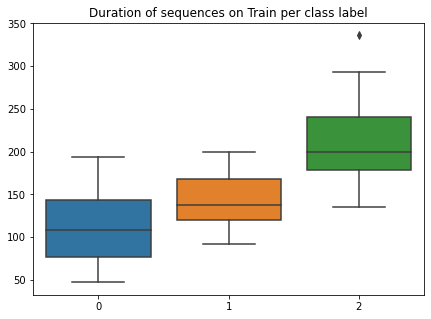

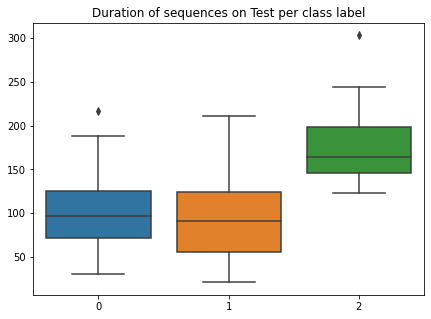

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

train_len = dict()
test_len = dict()
for s in n_states:
    train_len[s] = train_df[train_df.HS==s].value_counts(subset=['unit']).to_numpy()
    test_len[s] = test_df[test_df.HS==s].value_counts(subset=['unit']).to_numpy()
train_len = dict(sorted(train_len.items()))
test_len = dict(sorted(test_len.items()))

plt.figure(figsize=(7, 5))
plt.title('Duration of sequences on Train per class label')
sns.boxplot(data=list(test_len.values()))
plt.show()

plt.figure(figsize=(7, 5))
plt.title('Duration of sequences on Test per class label')
sns.boxplot(data=list(test_len.values()))
plt.show()

**2. Define the MI-iDT model to employ**

To define the model, import the `MilIdtTsc` class and configure the incremental decision tree to employ –HT, HATT, or HAT–, as well as the multi-instance parameters to create each bag of sub-sequences for each time series: instance length, stride between instances and number of relevant instances in each bag. Moreover, there are other additional parameters related to how to build the decision tree.

In this case, we are going to use the Hoeffding Anytime Tree as the base classifier, split each sequence into instances of 5 time steps, without overlapping between them, and look for 6 consecutive instances that represent the signature of the time series.

In [40]:
from milidt.mil_idt_tsc import MilIdtTsc

learner = MilIdtTsc(base_model='HATT', inst_len=5, inst_stride=5, k=6, grace_period=6e2, split_confidence=1e-7, seed=0)

learner.classifier

ExtremelyFastDecisionTreeClassifier(binary_split=False, grace_period=600.0,
                                    leaf_prediction='nba',
                                    max_byte_size=33554432,
                                    memory_estimate_period=1000000,
                                    min_samples_reevaluate=20, nb_threshold=0,
                                    nominal_attributes=None,
                                    split_confidence=1e-07,
                                    split_criterion='info_gain',
                                    stop_mem_management=False,
                                    tie_threshold=0.05)

**3. Train the model with the train set**

The `train` method of the `MilIdtTsc` class carries out the training process. This is an iterative process that looks for the most representative instances in each bag to reinforce the model and grow the base decision tree. The iterative search stop when they pass five iterations without improving the target metric, the accuracy of the classification with the training data.

The training method requires passing the data as a NumPy array with the sequence identifier in the first column and the class label in the last. The intermediate columns are used as the input of the machine learning method.

In [41]:
train_data = train_df[['unit'] + [f"s{i}" for i in range(1, 22)] + ['HS']].to_numpy()
train_result = learner.train(train_data=train_data, max_it=50, patience=5, reset_model=False, verbose=1)

Training
Iteration 0 of 50
Current accuracy: 0.33
Iteration 1 of 50
Current accuracy: 0.68
Iteration 2 of 50
Current accuracy: 0.97
Iteration 3 of 50
Current accuracy: 0.83
Iteration 4 of 50
Current accuracy: 0.72
Iteration 5 of 50
Current accuracy: 0.79
Iteration 6 of 50
Current accuracy: 0.74
Iteration 7 of 50
Current accuracy: 0.85


The method returns a dictionary with the results of the experimentation:

- Trained incremental decision tree.
- The actual labels of the time series used for training.
- The predicted labels of the time series used for training.
- The indexes of the instances selected as the most relevant in each bag.
- The execution time in seconds.

In [64]:
train_result.keys()

dict_keys(['model', 'y_true', 'y_pred', 'selection', 'history', 'exec_time'])

From these results, we can use any method of the `scikit-learn` `metrics` module to get the modeo performance in train time.

In [62]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, hamming_loss, jaccard_score, matthews_corrcoef, precision_score, recall_score

print(f"acc:\t\t\t {accuracy_score(train_result['y_true'], train_result['y_pred'])}")
print(f"balanced acc:\t\t {balanced_accuracy_score(train_result['y_true'], train_result['y_pred'])}")
print(f"macro f1:\t\t {f1_score(train_result['y_true'], train_result['y_pred'], average='macro')}") 
print(f"micro f1:\t\t {f1_score(train_result['y_true'], train_result['y_pred'], average='micro')}") 
print(f"f1:\t\t\t {f1_score(train_result['y_true'], train_result['y_pred'], average=None)}") 
print(f"macro precision:\t {precision_score(train_result['y_true'], train_result['y_pred'], average='macro')}") 
print(f"micro precision:\t {precision_score(train_result['y_true'], train_result['y_pred'], average='micro')}") 
print(f"precision:\t\t {precision_score(train_result['y_true'], train_result['y_pred'], average=None)}") 
print(f"macro recall:\t\t {recall_score(train_result['y_true'], train_result['y_pred'], average='macro')}") 
print(f"micro recall:\t\t {recall_score(train_result['y_true'], train_result['y_pred'], average='micro')}") 
print(f"recall:\t\t\t {recall_score(train_result['y_true'], train_result['y_pred'], average=None)}") 
print(f"hamming:\t\t {hamming_loss(train_result['y_true'], train_result['y_pred'])}") 
print(f"macro jaccard:\t\t {jaccard_score(train_result['y_true'], train_result['y_pred'], average='macro')}") 
print(f"micro jaccard:\t\t {jaccard_score(train_result['y_true'], train_result['y_pred'], average='micro')}") 
print(f"jaccard:\t\t {jaccard_score(train_result['y_true'], train_result['y_pred'], average=None)}") 
print(f"matthews_corr:\t\t {matthews_corrcoef(train_result['y_true'], train_result['y_pred'])}")

acc:			 0.97
balanced acc:		 0.9699940582293524
macro f1:		 0.9701154553320355
micro f1:		 0.97
f1:			 [0.96875    0.95652174 0.98507463]
macro precision:	 0.9711484593837535
micro precision:	 0.97
precision:		 [1.         0.94285714 0.97058824]
macro recall:		 0.9699940582293524
micro recall:		 0.97
recall:			 [0.93939394 0.97058824 1.        ]
hamming:		 0.03
macro jaccard:		 0.9422162804515746
micro jaccard:		 0.941747572815534
jaccard:		 [0.93939394 0.91666667 0.97058824]
matthews_corr:		 0.9554189653716565


**4. Test the predictive performance of the model with the test set**

The method `test` of the class `MilIdtTsc` tests the performance of the classifier with data not used to fit it. This method returns a dictionary equivalent to that returned by the `train` method but without the incremental decision tree since it is not modified in the test process.

In [46]:
test_data = test_df[['unit'] + [f"s{i}" for i in range(1, 22)] + ['HS']].to_numpy()
test_result = learner.test(test_data=test_data, verbose=1)
test_result

Testing
Accuracy on test: 0.95


{'y_true': array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 2., 0., 1., 0., 2., 0., 0., 1., 1., 1., 1., 2., 1., 1., 2.,
        2., 2., 1., 2., 0., 2., 2., 2., 1., 0., 1., 2., 1., 0., 2., 0., 1.,
        0., 2., 0., 0., 2., 1., 2., 0., 1., 2., 1., 1., 2., 0., 2., 0., 2.,
        0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 0., 2., 2., 0., 1., 1.,
        1., 0., 1., 1., 2., 2., 2., 2., 2., 0., 0., 0., 1., 0., 2.]),
 'y_pred': array([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1,
        0, 2, 0, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2, 1, 2, 1, 0,
        1, 2, 1, 0, 2, 0, 1, 1, 2, 0, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 2,
        0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 2, 0, 1, 1, 1, 0, 1,
        1, 2, 2, 2, 2, 1, 0, 0, 0, 1, 0, 2]),
 'selection': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  31,

We can use the fields of the actual and predicted labels, `y_true` and `y_test` respectively, to obtain any available metric in `scikit-learn` or other Machine Learning library, as we did with to get the performance in train time.

In [63]:
print(f"acc:\t\t\t {accuracy_score(test_result['y_true'], test_result['y_pred'])}")
print(f"balanced acc:\t\t {balanced_accuracy_score(test_result['y_true'], test_result['y_pred'])}")
print(f"macro f1:\t\t {f1_score(test_result['y_true'], test_result['y_pred'], average='macro')}") 
print(f"micro f1:\t\t {f1_score(test_result['y_true'], test_result['y_pred'], average='micro')}") 
print(f"f1:\t\t\t {f1_score(test_result['y_true'], test_result['y_pred'], average=None)}") 
print(f"macro precision:\t {precision_score(test_result['y_true'], test_result['y_pred'], average='macro')}") 
print(f"micro precision:\t {precision_score(test_result['y_true'], test_result['y_pred'], average='micro')}") 
print(f"precision:\t\t {precision_score(test_result['y_true'], test_result['y_pred'], average=None)}") 
print(f"macro recall:\t\t {recall_score(test_result['y_true'], test_result['y_pred'], average='macro')}") 
print(f"micro recall:\t\t {recall_score(test_result['y_true'], test_result['y_pred'], average='micro')}") 
print(f"recall:\t\t\t {recall_score(test_result['y_true'], test_result['y_pred'], average=None)}") 
print(f"hamming:\t\t {hamming_loss(test_result['y_true'], test_result['y_pred'])}") 
print(f"macro jaccard:\t\t {jaccard_score(test_result['y_true'], test_result['y_pred'], average='macro')}") 
print(f"micro jaccard:\t\t {jaccard_score(test_result['y_true'], test_result['y_pred'], average='micro')}") 
print(f"jaccard:\t\t {jaccard_score(test_result['y_true'], test_result['y_pred'], average=None)}") 
print(f"matthews_corr:\t\t {matthews_corrcoef(test_result['y_true'], test_result['y_pred'])}")

acc:			 0.95
balanced acc:		 0.9495008104921898
macro f1:		 0.9502326032176779
micro f1:		 0.9500000000000001
f1:			 [0.96103896 0.92537313 0.96428571]
macro precision:	 0.9531328320802005
micro precision:	 0.95
precision:		 [0.97368421 0.88571429 1.        ]
macro recall:		 0.9495008104921898
micro recall:		 0.95
recall:			 [0.94871795 0.96875    0.93103448]
hamming:		 0.05
macro jaccard:		 0.9057151979565773
micro jaccard:		 0.9047619047619048
jaccard:		 [0.925      0.86111111 0.93103448]
matthews_corr:		 0.9253938439386292


**5. Interpretative support to the solution**

Predicting a label for a given time series is not very useful to help to avoid damage in the context of predictive maintenance, although its accuracy. Thus, this library provides additional tools to increase the interpretability of the provided solutions. These are, on the one hand, the generated decision tree that allows one to follow the path to obtain a health state, the confidence in each decision, and the attributes implied in it.

In [43]:
print(train_result['model'].get_model_description())

if Attribute 10 <= 47.56818181818182:
  if Attribute 11 <= 521.6727272727272:
    Leaf = Class 1 | {0: 595.3094689295463, 1: 843.7110398889607, 2: 299.31681000435987}
  if Attribute 11 > 521.6727272727272:
    Leaf = Class 0 | {0: 1962.6905310704537, 1: 693.2889601110393, 2: 297.68318999564013}
if Attribute 10 > 47.56818181818182:
  if Attribute 10 <= 47.71909090909091:
    if Attribute 8 <= 9083.043636363636:
      Leaf = Class 1 | {0: 74.0, 1: 611.9706849735256, 2: 87.4312241566488}
    if Attribute 8 > 9083.043636363636:
      Leaf = Class 2 | {1: 50.029315026474364, 2: 81.5687758433512}
  if Attribute 10 > 47.71909090909091:
    Leaf = Class 2 | {0.0: 1.0, 1: 264.27347300060023, 2: 2101.6382909552503}



On the other hand, we can visualize the most relevant subsequence of each time series employing the *k* consecutive instances that maximize the likelihood of the predicted class. Here is a random sequence and its selection across all the attributes, or dimensions, that compose the problem.

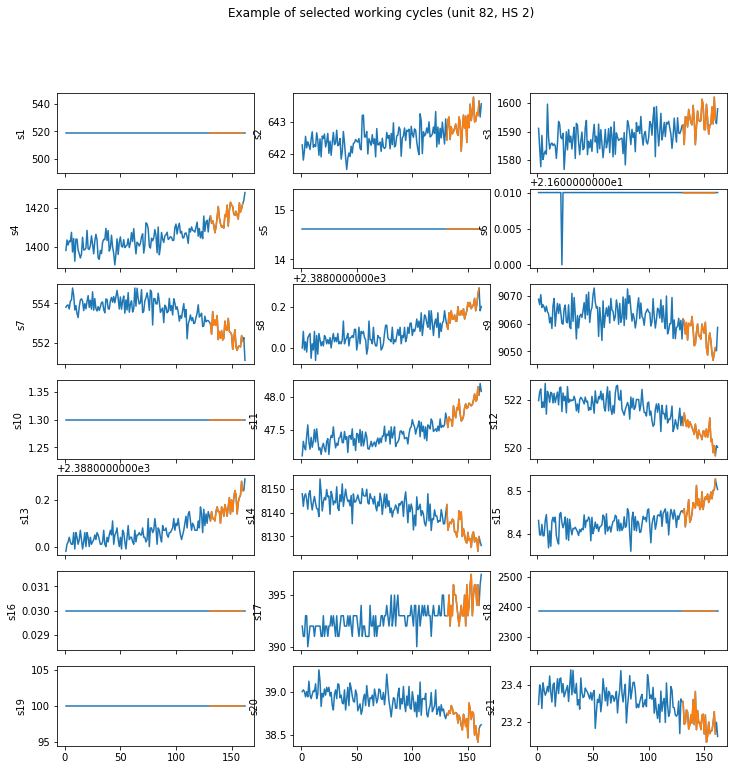

In [56]:
from random import randint

test_df['select'] = np.in1d(test_df.index.to_numpy(), test_result['selection'])

unit = randint(1, test_df.unit.max())
sequence = test_df[(test_df.unit == unit)]

columns = [f's{i}' for i in range(1, 22)]
fig, ax = plt.subplots(7, 3, sharex='all', figsize=(12, 12))
for i, ax_i in zip(columns, ax.reshape(-1)):
    ax_i.plot(sequence['cycle'], sequence[i])
    ax_i.plot(sequence[sequence['select']]['cycle'], sequence[sequence['select']][i])
    ax_i.set_ylabel(i)
fig.suptitle(f"Example of selected working cycles (unit {unit}, HS {sequence.HS.max()})")
plt.show()